#Imports & basic config

In [1]:
!pip install -q "transformers>=4.48.0" peft kagglehub fire

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 4.1 MB/s eta 0:00:00


In [2]:
!pip install -q "transformers>=4.48.0" peft kagglehub fire sentence-transformers datasets


In [ ]:
import transformers
print(transformers.__version__)


In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
FOLDERNAME = 'UW_Courses/eep596 dl/final_project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/UW_Courses/eep596 dl/final_project


In [ ]:

import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tarfile
import urllib.request
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split

# Hugging Face Datasets
# from datasets import load_dataset # Not used for DAQUAR anymore due to 404

# Models
from torchvision import models, transforms
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer, util

# Torch Utils
from torch.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from torch.utils.checkpoint import checkpoint
import kagglehub


In [ ]:

# ==========================================
# 2. Configuration
# ==========================================
class Config:
    seed = 42
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Training Config
    batch_size = 32
    num_epochs = 100
    learning_rate = 5e-5
    weight_decay = 1e-4
    max_len = 64
    patience = 20

    # Paths
    # kagglehub will determine the root path
    checkpoint_dir = Path("./daquar_checkpoints")
    best_model_path = checkpoint_dir / "best_model.pth"
    # [NEW] Path for resuming training
    resume_path = checkpoint_dir / "latest_checkpoint.pth"

# Ensure reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(Config.seed)
Config.checkpoint_dir.mkdir(parents=True, exist_ok=True)
print(f"Device: {Config.device}")


Device: cuda


#VQADataset + training wrapper dataset

In [ ]:

# ==========================================
# 3. Data Preparation (Via KaggleHub)
# ==========================================
def prepare_daquar_data():
    print("Downloading DAQUAR dataset (bhavikardeshna version) from Kaggle...")

    # [FIX] Authenticate with Kaggle to solve 403 Forbidden error
    print("⚠️ Authentication required for Kaggle dataset.")
    print("   If prompted, please enter your Kaggle username and key.")
    print("   (Get key from: https://www.kaggle.com/settings -> Create New Token)")
    try:
        kagglehub.login()
    except Exception as e:
        print(f"Warning during login: {e}")

    # Use the processed DAQUAR dataset
    try:
        dataset_path = kagglehub.dataset_download("bhavikardeshna/visual-question-answering-computer-vision-nlp")
        root_dir = Path(dataset_path)
        print(f"Dataset downloaded to: {root_dir}")
    except Exception as e:
        print("\n❌ Download Failed.")
        raise RuntimeError(f"Failed to download dataset: {e}")

    # 1. Locate Dataset Folder
    # This dataset usually extracts into a 'dataset' subfolder
    dataset_dir = root_dir / "dataset"
    if not dataset_dir.exists():
        # Fallback: maybe it's in the root
        if (root_dir / "images").exists():
            dataset_dir = root_dir
        else:
            print(f"Contents of root: {[x.name for x in root_dir.iterdir()]}")
            raise FileNotFoundError("Could not find 'dataset' or 'images' folder.")

    image_dir = dataset_dir / "images"
    if not image_dir.exists():
        raise FileNotFoundError(f"Images folder not found at {image_dir}")

    print(f"Images located at: {image_dir}")

    # 2. Parse CSV Files
    # This dataset typically comes with data_train.csv and data_eval.csv
    train_csv = dataset_dir / "data_train.csv"
    eval_csv = dataset_dir / "data_eval.csv"

    dfs = []
    if train_csv.exists():
        print("Loading data_train.csv...")
        dfs.append(pd.read_csv(train_csv))

    if eval_csv.exists():
        print("Loading data_eval.csv...")
        dfs.append(pd.read_csv(eval_csv))

    if not dfs:
        raise FileNotFoundError("No CSV files found in dataset!")

    df = pd.concat(dfs, ignore_index=True)

    # 3. Clean and Format Data
    # Ensure columns exist
    required_cols = ['image_id', 'question', 'answer']
    for col in required_cols:
        if col not in df.columns:
            # Try to rename if names differ (e.g. sometimes just 'image' or 'label')
            if 'label' in df.columns and col == 'answer':
                df = df.rename(columns={'label': 'answer'})
            else:
                raise ValueError(f"Missing column '{col}' in CSV. Found: {df.columns}")

    # Construct full image paths
    def get_image_path(img_id):
        # The CSV usually has IDs like "image1"
        img_id = str(img_id).strip()
        path_png = image_dir / f"{img_id}.png"
        path_jpg = image_dir / f"{img_id}.jpg"

        if path_png.exists(): return str(path_png)
        if path_jpg.exists(): return str(path_jpg)
        return None

    tqdm.pandas(desc="Verifying images")
    df['image_path'] = df['image_id'].progress_apply(get_image_path)

    # Drop rows where image wasn't found
    initial_len = len(df)
    df = df.dropna(subset=['image_path'])
    if len(df) < initial_len:
        print(f"⚠️ Warning: Dropped {initial_len - len(df)} samples due to missing images.")

    # Clean text
    df['question'] = df['question'].astype(str).str.strip()
    df['answer'] = df['answer'].astype(str).str.strip()

    return df

print("Preparing Data...")
full_df = prepare_daquar_data()
print(f"Total valid samples loaded: {len(full_df)}")

# 3.1 Data Splitting
# Split Train -> Train (80%) / Val (10%) / Test (10%)
train_df, temp_df = train_test_split(full_df, test_size=0.2, random_state=Config.seed)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=Config.seed)

print(f"Train size: {len(train_df)}")
print(f"Val size:   {len(val_df)}")
print(f"Test size:  {len(test_df)}")

# 3.2 Build Vocabulary
all_answers = full_df['answer'].tolist()
counter = Counter(all_answers)
vocab = sorted(counter.keys())

answer2idx = {ans: i for i, ans in enumerate(vocab)}
idx2answer = {i: ans for i, ans in enumerate(vocab)}
NUM_ANSWERS = len(answer2idx)

print(f"Total Unique Answers (Classes): {NUM_ANSWERS}")


Preparing Data...
⚠️ Authentication required for Kaggle dataset.
   If prompted, please enter your Kaggle username and key.
   (Get key from: https://www.kaggle.com/settings -> Create New Token)


100%|██████████| 411M/411M [00:09<00:00, 43.4MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/bhavikardeshna/visual-question-answering-computer-vision-nlp/versions/1
Images located at: /root/.cache/kagglehub/datasets/bhavikardeshna/visual-question-answering-computer-vision-nlp/versions/1/dataset/images
Loading data_train.csv...
Loading data_eval.csv...


Verifying images:   0%|          | 0/12468 [00:00<?, ?it/s]

Total valid samples loaded: 12468
Train size: 9974
Val size:   1247
Test size:  1247
Total Unique Answers (Classes): 1443


#Prepare Kaggle VQA data → JSON + 80/10/10 split

In [ ]:

# ==========================================
# 4. Dataset & Transforms
# ==========================================

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class DaquarDataset(Dataset):
    def __init__(self, df, transform, tokenizer, answer2idx, max_len=64):
        self.df = df
        self.transform = transform
        self.tokenizer = tokenizer
        self.answer2idx = answer2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # 1. Image
        # [Modified] Load from path string
        img_path = row['image_path']
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            # Fallback for broken images
            print(f"Error loading {img_path}: {e}")
            image = Image.new('RGB', (224, 224))

        if self.transform:
            image = self.transform(image)

        # 2. Text
        question = str(row['question'])
        encoding = self.tokenizer(
            question,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_len
        )
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)

        # 3. Label
        answer = str(row['answer'])
        label = self.answer2idx.get(answer, 0)

        return image, input_ids, attention_mask, torch.tensor(label, dtype=torch.long)

# Create DataLoaders
# Create DataLoaders
# [FIX] Set num_workers=0 to avoid multiprocessing errors in Colab ("AssertionError: can only test a child process")
train_ds = DaquarDataset(train_df, train_transform, tokenizer, answer2idx, Config.max_len)
val_ds = DaquarDataset(val_df, val_transform, tokenizer, answer2idx, Config.max_len)
test_ds = DaquarDataset(test_df, val_transform, tokenizer, answer2idx, Config.max_len)

train_loader = DataLoader(train_ds, batch_size=Config.batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=Config.batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=Config.batch_size, shuffle=False, num_workers=0)


#Model Training

In [ ]:

# ==========================================
# 5. Model Architecture (ResNet50 + BERT)
# ==========================================
class ResNetBERT_VQA(nn.Module):
    def __init__(self, num_answers):
        super().__init__()
        # Visual Encoder
        self.cnn = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.cnn.fc = nn.Identity() # Output: 2048

        # Text Encoder
        self.bert = BertModel.from_pretrained('bert-base-uncased') # Output: 768

        # Fusion
        self.fc1 = nn.Linear(2048 + 768, 1024)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, num_answers)

    def forward(self, images, input_ids, attention_mask):
        # Image Features
        img_feat = self.cnn(images)

        # Text Features (Checkpointing to save memory)
        if self.training:
            bert_out = checkpoint(
                lambda i, m: self.bert(input_ids=i, attention_mask=m),
                input_ids, attention_mask, use_reentrant=False
            )
        else:
            bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        txt_feat = bert_out.last_hidden_state[:, 0, :] # [CLS] token

        # Concatenate
        combined = torch.cat((img_feat, txt_feat), dim=1)

        # Classification
        x = self.fc1(combined)
        x = torch.relu(x)
        x = self.dropout(x)
        logits = self.fc2(x)

        return logits

model = ResNetBERT_VQA(NUM_ANSWERS).to(Config.device)

In [ ]:

# ==========================================
# 6. Training Loop (With Resume Logic)
# ==========================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=Config.learning_rate, weight_decay=Config.weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Config.num_epochs)
scaler = GradScaler()

# Resume Variables
start_epoch = 0
best_val_acc = 0.0
early_stopping_counter = 0
history = []

# [NEW] Resume Logic
if Config.resume_path.exists():
    print(f"🔄 Found checkpoint at {Config.resume_path}. Resuming training...")
    # Rename to ckpt to avoid shadowing 'checkpoint' function
    ckpt = torch.load(Config.resume_path, map_location=Config.device)

    model.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    scheduler.load_state_dict(ckpt['scheduler_state_dict'])
    if 'scaler_state_dict' in ckpt:
        scaler.load_state_dict(ckpt['scaler_state_dict'])

    start_epoch = ckpt['epoch'] + 1
    best_val_acc = ckpt['best_val_acc']
    early_stopping_counter = ckpt['early_stopping_counter']
    history = ckpt.get('history', [])

    print(f"   >>> Resuming from Epoch {start_epoch+1}")
    print(f"   >>> Best Val Acc so far: {best_val_acc:.4f}")
else:
    print("🚀 No checkpoint found. Starting training from scratch.")

print("Starting Training on DAQUAR...")

for epoch in range(start_epoch, Config.num_epochs):
    # Train
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for imgs, ids, mask, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        imgs, ids, mask, labels = imgs.to(Config.device), ids.to(Config.device), mask.to(Config.device), labels.to(Config.device)

        optimizer.zero_grad()

        with autocast("cuda"):
            outputs = model(imgs, ids, mask)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_acc = train_correct / train_total

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for imgs, ids, mask, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            imgs, ids, mask, labels = imgs.to(Config.device), ids.to(Config.device), mask.to(Config.device), labels.to(Config.device)

            with autocast("cuda"):
                outputs = model(imgs, ids, mask)
                loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total

    scheduler.step()

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f} Acc={train_acc:.4f} | Val Loss={avg_val_loss:.4f} Acc={val_acc:.4f}")

    history.append({
        "epoch": epoch+1,
        "train_loss": avg_train_loss, "val_loss": avg_val_loss,
        "train_acc": train_acc, "val_acc": val_acc
    })

    # Save Best Model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        early_stopping_counter = 0
        # Save Best Model (Full state for safety)
        best_state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
             # No need to save other states for best model if only used for eval
        }
        torch.save(best_state, Config.best_model_path)
        print(f">>> 🌟 New Best Model Saved! Acc: {best_val_acc:.4f}")
    else:
        early_stopping_counter += 1
        print(f"   >>> No improvement. Counter: {early_stopping_counter}/{Config.patience}")

    # [NEW] Save Latest Checkpoint (Overwrite every epoch)
    latest_state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'best_val_acc': best_val_acc,
        'early_stopping_counter': early_stopping_counter,
        'history': history
    }
    torch.save(latest_state, Config.resume_path)

    if early_stopping_counter >= Config.patience:
        print("🛑 Early stopping triggered.")
        break

🔄 Found checkpoint at daquar_checkpoints/latest_checkpoint.pth. Resuming training...
   >>> Resuming from Epoch 25
   >>> Best Val Acc so far: 0.2863
Starting Training on DAQUAR...


Epoch 25 [Train]:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 25 [Val]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 25: Train Loss=0.3966 Acc=0.9222 | Val Loss=6.2235 Acc=0.2743
   >>> No improvement. Counter: 11/20


Epoch 26 [Train]:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 26 [Val]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 26: Train Loss=0.3153 Acc=0.9436 | Val Loss=6.5209 Acc=0.2702
   >>> No improvement. Counter: 12/20


Epoch 27 [Train]:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 27 [Val]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 27: Train Loss=0.6856 Acc=0.8133 | Val Loss=6.2130 Acc=0.2678
   >>> No improvement. Counter: 13/20


Epoch 28 [Train]:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 28 [Val]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 28: Train Loss=0.6367 Acc=0.8324 | Val Loss=6.1704 Acc=0.2686
   >>> No improvement. Counter: 14/20


Epoch 29 [Train]:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 29 [Val]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 29: Train Loss=0.5561 Acc=0.8494 | Val Loss=6.4405 Acc=0.2727
   >>> No improvement. Counter: 15/20


Epoch 30 [Train]:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 30 [Val]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 30: Train Loss=0.4728 Acc=0.8761 | Val Loss=6.4869 Acc=0.2638
   >>> No improvement. Counter: 16/20


Epoch 31 [Train]:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 31 [Val]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 31: Train Loss=0.4254 Acc=0.8868 | Val Loss=6.6511 Acc=0.2670
   >>> No improvement. Counter: 17/20


Epoch 32 [Train]:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 32 [Val]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 32: Train Loss=0.3840 Acc=0.8987 | Val Loss=6.7659 Acc=0.2606
   >>> No improvement. Counter: 18/20


Epoch 33 [Train]:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 33 [Val]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 33: Train Loss=0.3537 Acc=0.9063 | Val Loss=6.8758 Acc=0.2727
   >>> No improvement. Counter: 19/20


Epoch 34 [Train]:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 34 [Val]:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 34: Train Loss=0.3315 Acc=0.9138 | Val Loss=6.9999 Acc=0.2630
   >>> No improvement. Counter: 20/20
🛑 Early stopping triggered.


#Evaluation


Running Final Evaluation...
Loaded best model.


Testing:   0%|          | 0/39 [00:00<?, ?it/s]

Final Test Accuracy: 0.2815
Final SBERT Similarity: 0.5074


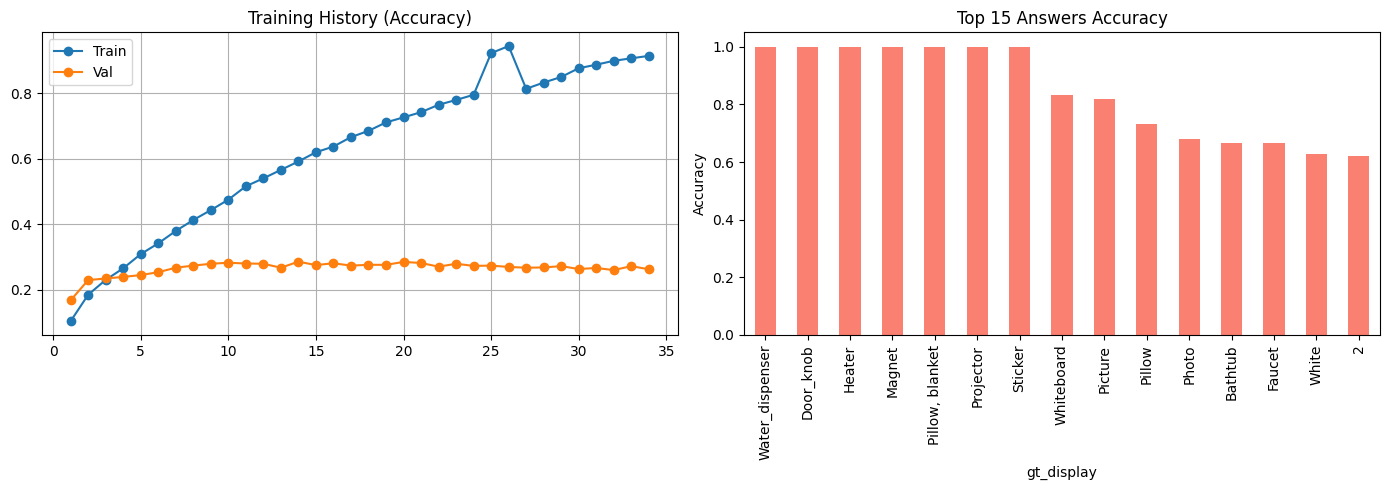


--- Qualitative Examples ---
GT: column | Pred: chair | Sim: 0.2863
GT: table | Pred: bookshelf | Sim: 0.2726
GT: table | Pred: fireplace | Sim: 0.1998
GT: book | Pred: chair | Sim: 0.2429
GT: television | Pred: picture | Sim: 0.2181


In [ ]:

# ==========================================
# 7. Evaluation & Visualization
# ==========================================
print("\nRunning Final Evaluation...")
if Config.best_model_path.exists():
    # [FIX] Safe loading of state dict
    ckpt = torch.load(Config.best_model_path, map_location=Config.device)
    if 'model_state_dict' in ckpt:
        model.load_state_dict(ckpt['model_state_dict'])
    else:
        model.load_state_dict(ckpt)
    print("Loaded best model.")
else:
    print("Best model not found, using current weights.")

model.eval()

sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

predictions = []
ground_truths = []
similarities = []

with torch.no_grad():
    for imgs, ids, mask, labels in tqdm(test_loader, desc="Testing"):
        imgs, ids, mask, labels = imgs.to(Config.device), ids.to(Config.device), mask.to(Config.device), labels.to(Config.device)

        with autocast("cuda"):
            outputs = model(imgs, ids, mask)

        _, preds = torch.max(outputs, 1)

        for p_idx, g_idx in zip(preds, labels):
            pred_text = idx2answer[p_idx.item()]
            gt_text = idx2answer[g_idx.item()]

            predictions.append(pred_text)
            ground_truths.append(gt_text)

            emb1 = sbert_model.encode(pred_text, convert_to_tensor=True)
            emb2 = sbert_model.encode(gt_text, convert_to_tensor=True)
            sim = util.cos_sim(emb1, emb2).item()
            similarities.append(sim)

df_results = pd.DataFrame({
    "gt_answer": ground_truths,
    "pred_answer": predictions,
    "similarity": similarities
})

# Normalize for metric (ignore case)
df_results['is_correct'] = df_results.apply(
    lambda x: 1 if x['gt_answer'].lower().strip() == x['pred_answer'].lower().strip() else 0, axis=1
)

final_acc = df_results['is_correct'].mean()
avg_sim = df_results['similarity'].mean()

print("="*30)
print(f"Final Test Accuracy: {final_acc:.4f}")
print(f"Final SBERT Similarity: {avg_sim:.4f}")
print("="*30)

# Plots
plt.figure(figsize=(14, 5))

# History
if history:
    epochs = [x['epoch'] for x in history]
    train_accs = [x['train_acc'] for x in history]
    val_accs = [x['val_acc'] for x in history]

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accs, label='Train', marker='o')
    plt.plot(epochs, val_accs, label='Val', marker='o')
    plt.title('Training History (Accuracy)')
    plt.legend()
    plt.grid(True)

# Top Answer Performance
df_results['gt_display'] = df_results['gt_answer'].apply(lambda x: x.lower().strip().capitalize())
stats = df_results.groupby("gt_display")["is_correct"].mean().sort_values(ascending=False).head(15)

plt.subplot(1, 2, 2)
stats.plot(kind='bar', color='salmon')
plt.title("Top 15 Answers Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)

plt.tight_layout()
plt.show()

# Sample Predictions
print("\n--- Qualitative Examples ---")
for i in range(5):
    if i >= len(df_results): break
    row = df_results.iloc[i]
    print(f"GT: {row['gt_answer']} | Pred: {row['pred_answer']} | Sim: {row['similarity']:.4f}")

Total distinct answers: 373
             freq       acc
gt_answer                  
2              50  0.620000
Table          49  0.285714
White          35  0.628571
Chair          34  0.470588
3              33  0.363636
Cabinet        28  0.392857
Window         28  0.285714
Photo          28  0.678571
Lamp           24  0.333333
1              24  0.333333
Picture        22  0.818182
Bed            20  0.400000
Red            19  0.368421
Garbage_bin    17  0.176471
4              17  0.294118
Door           17  0.294118
Brown          16  0.375000
Pillow         15  0.733333
Sofa           15  0.466667
Books          15  0.600000


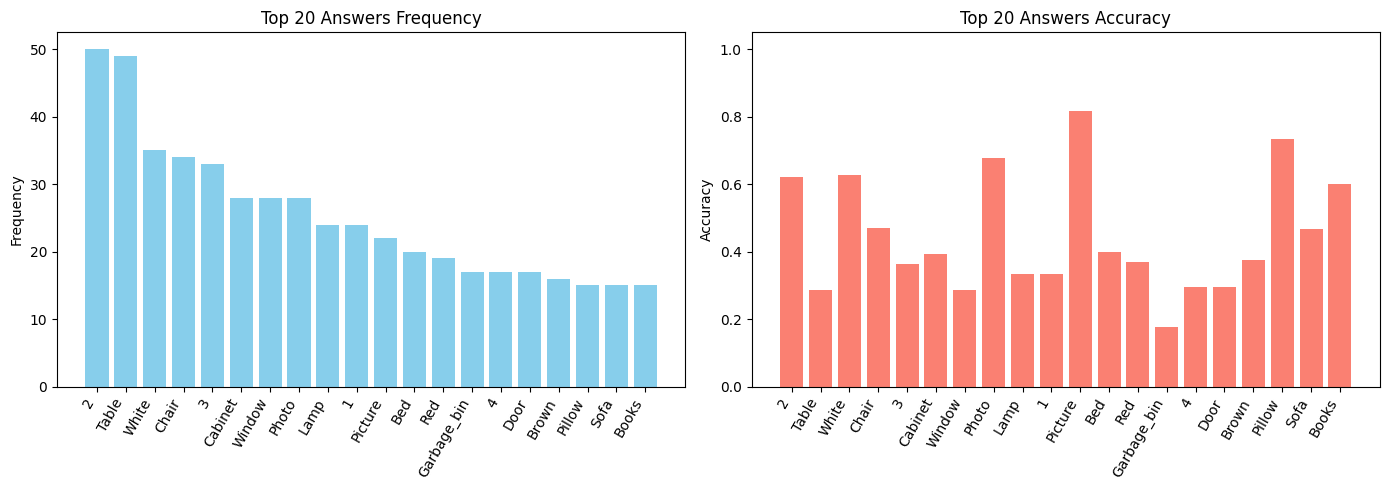

In [ ]:
# 10.1 Statistics
# [MODIFIED] Normalize gt_answer directly to merge "no"/"No" (Capitalize for display)
df_results['gt_answer'] = df_results['gt_answer'].apply(lambda x: x.lower().strip().capitalize())

# 統計分析 (回復為您原本的寫法)
stats = (
    df_results
    .groupby("gt_answer")["is_correct"]
    .agg(["count", "mean"])        # count: 出現次數, mean: 正確率
    .rename(columns={"count": "freq", "mean": "acc"})
    .sort_values("freq", ascending=False)
)

print(f"Total distinct answers: {len(stats)}")
TOP_N = 20
top_stats = stats.head(TOP_N)
print(top_stats)

# 畫圖
plt.figure(figsize=(14, 5))

# 1. 頻率圖
plt.subplot(1, 2, 1)
plt.bar(range(len(top_stats)), top_stats["freq"], color='skyblue')
plt.xticks(range(len(top_stats)), top_stats.index, rotation=60, ha="right")
plt.ylabel("Frequency")
plt.title(f"Top {TOP_N} Answers Frequency")

# 2. 正確率圖
plt.subplot(1, 2, 2)
plt.bar(range(len(top_stats)), top_stats["acc"], color='salmon')
plt.xticks(range(len(top_stats)), top_stats.index, rotation=60, ha="right")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.title(f"Top {TOP_N} Answers Accuracy")

plt.tight_layout()
plt.show()


Plotting Training History...

Plotting Training History...


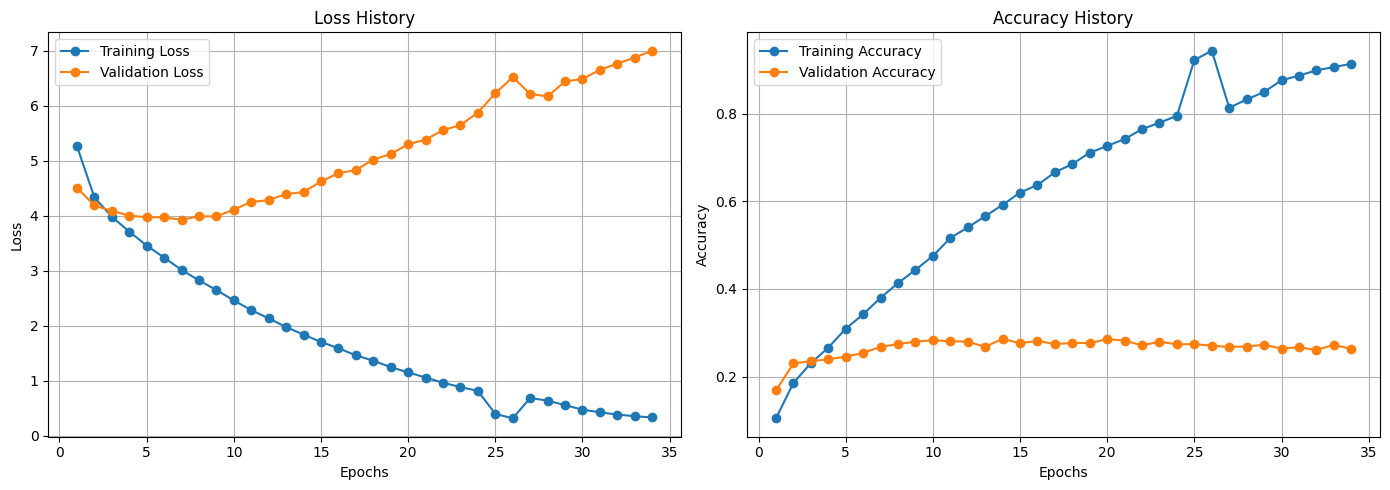

In [ ]:

# ==========================================
# 8. Training History Visualization
# ==========================================
print("\nPlotting Training History...")

# 10.2 Training History
print("\nPlotting Training History...")
if history:
    epochs = [x['epoch'] for x in history]
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    train_accs = [x['train_acc'] for x in history]
    val_accs = [x['val_acc'] for x in history]

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss History')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_accs, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy History')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# ==========================================
# 9. Qualitative Results (Images & Predictions)
# ==========================================
print("\nGenerating Qualitative Examples...")
def preprocess_answer(answer):
    return answer.replace('_', ' ')

count = 0
max_examples = 10

with torch.no_grad():
    for batch_idx, (imgs, ids, mask, labels) in enumerate(test_loader):
        imgs = imgs.to(Config.device)
        ids = ids.to(Config.device)
        mask = mask.to(Config.device)
        labels = labels.to(Config.device)

        with torch.amp.autocast("cuda"):
            outputs = model(imgs, ids, mask)

        _, preds = torch.max(outputs, 1)

        for i in range(imgs.size(0)):
            if count >= max_examples:
                break

            pred_idx = preds[i].item()
            label_idx = labels[i].item()

            predicted_answer = preprocess_answer(idx2answer[pred_idx])
            actual_answer = preprocess_answer(idx2answer[label_idx])

            # Fetch Question
            global_idx = batch_idx * test_loader.batch_size + i
            if global_idx < len(test_ds):
                question = test_ds.df.iloc[global_idx]['question']
            else:
                question = "Unknown"

            # Re-calculate sim just for display
            emb1 = sbert_model.encode(predicted_answer, convert_to_tensor=True)
            emb2 = sbert_model.encode(actual_answer, convert_to_tensor=True)
            similarity = util.cos_sim(emb1, emb2).item()

            # Denormalize Image
            img_tensor = imgs[i].cpu()
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            img_disp = img_tensor * std + mean
            img_disp = torch.clamp(img_disp, 0, 1)
            img_np = img_disp.permute(1, 2, 0).numpy()

            plt.figure(figsize=(6, 6))
            plt.imshow(img_np)
            plt.title(f"Q: {question}\nPred: {predicted_answer} | GT: {actual_answer}\nSBERT Sim: {similarity:.4f}", fontsize=10)
            plt.axis('off')
            plt.show()

            count += 1

        if count >= max_examples:
            break

Output hidden; open in https://colab.research.google.com to view.